#Create a Model for Position Complexity given PGN and Evaluations

Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Imports

In [1]:
%tensorflow_version 1.x

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import Sequential 

import chess
import chess.pgn
import chess.engine
from tqdm import tqdm 
import random

!pip install python-chess --upgrade

TensorFlow 1.x selected.
Requirement already up-to-date: python-chess in /usr/local/lib/python3.6/dist-packages (0.31.1)


Methods to Process PGN and FEN

In [2]:
# Remove the move tags, keep only information about the board
def process_fen(unprocessed_fen): 
  split = unprocessed_fen.split(" ")
  new_fen = unprocessed_fen
  if len(split) == 6:
    new_fen = ""
    for i in range(len(split) - 2):
      new_fen = new_fen + split[i] + " "
  
  return new_fen

# Return a clean PGN file
def reset_pgn():
  return open("/content/drive/My Drive/MassChessModelTesting/data.pgn")

# Check whether a string is a float
def isfloat(string):
  try:
    float(string)
  except:
    return False
  return True

print(isfloat("-102"))
print(isfloat("23.5"))
print(isfloat("NA"))

True
True
False


Methods to process FEN to Model Input

In [3]:
pieces_order = 'KQRBNPkqrbnp' # 8x8x12
ind = {pieces_order[i]: i for i in range(12)}
print("Ind", ind)

# feed in board part of fen 
def replace_tags_board(board_san):
    board_san = board_san.replace("2", "11")
    board_san = board_san.replace("3", "111")
    board_san = board_san.replace("4", "1111")
    board_san = board_san.replace("5", "11111")
    board_san = board_san.replace("6", "111111")
    board_san = board_san.replace("7", "1111111")
    board_san = board_san.replace("8", "11111111")
    return board_san.replace("/", "")

# Process FEN to 8 x 8 x 12 board
def board_planes(fen): # 8 x 8 x 12
  board_state = replace_tags_board(fen) # rnbqkbnrppp11ppp1111p111111pP1111111111111111111PPPP1PPPRNBQKBNR
  pieces_both = np.zeros(shape=(12, 8, 8), dtype=np.float32)

  for rank in range(8):
      for file in range(8):
          piece = board_state[rank * 8 + file]
          if piece.isalpha(): # if its a letter
            pieces_both[ind[piece]][rank][file] = 1

  assert pieces_both.shape == (12, 8, 8)
  return pieces_both

# Input full FEN -> Board Pieces + Turn
def flat_input(fen):
  split = fen.split(' ')
  
  color = np.zeros((1), dtype=np.float32)
  color[0] = 1 if split[1] == 'w' else 0

  # Board Input
  board_input = np.ndarray.flatten(board_planes(split[0]))
  assert board_input.shape == (768,)
  
  ret = np.concatenate((color, board_input))
  return ret

Ind {'K': 0, 'Q': 1, 'R': 2, 'B': 3, 'N': 4, 'P': 5, 'k': 6, 'q': 7, 'r': 8, 'b': 9, 'n': 10, 'p': 11}


Test to Process Errors from Games

In [4]:
game_data = pd.read_csv("/content/drive/My Drive/MassChessModelTesting/stockfish.csv")
# print(game_data)
game_evals = game_data['MoveScores'][26]
processed = game_evals.split(" ")

print(processed)
for i in range(len(processed)):
  if not isfloat(processed[i - 1]) or not isfloat(processed[i]): # If you get NA
    error = "NA"
  elif i > 0:
    error = int(processed[i]) - int(processed[i - 1]) if i % 2 == 1 else int(processed[i - 1]) - int(processed[i])
  else:
    error = 0
  print("Move:", i//2+1, "Eval:", processed[i], 
        "Error:", error)

['18', '29', '-8', '-8', '-6', '27', '27', '13', '-9', '18', '-17', '-19', '-32', '-6', '-2', '3', '-11', '3', '-14', '16', '-16', '-5', '-37', '21', '15', '14', '6', '40', '43', '34', '33', '71', '88', '60', '54', '56', '45', '46', '56', '65', '73', '100', '85', '101', '47', '44', '46', '48', '43', '48', '60', '62', '65', '43', '21', '34', '39', '48', '46', '103', '57', '74', '77', '75', '81', '91', '50', '39', '65', '86', '17', '93', '90', '106', '-1', '32', '-44', '-31', '-24', '-10', '-49', '-24', '-36', '-48', '-77', '-30', '-21', '-27', '-23', '491', '505', '514', '498', '798', '796', '2093', '10202', '10682', '2407', '841', '3781', '969', '1678', '1674', '1211', '4835', '4835', '862', '4843', 'NA', '4850']
Move: 1 Eval: 18 Error: 0
Move: 1 Eval: 29 Error: 11
Move: 2 Eval: -8 Error: 37
Move: 2 Eval: -8 Error: 0
Move: 3 Eval: -6 Error: -2
Move: 3 Eval: 27 Error: 33
Move: 4 Eval: 27 Error: 0
Move: 4 Eval: 13 Error: -14
Move: 5 Eval: -9 Error: 22
Move: 5 Eval: 18 Error: 27
Move: 6 E

Collect FENs and Errors from Games

In [5]:
global_fen_list = [[], [], [], [], []] # 5 inner lists for the 5 rating categories
global_error_list = [[], [], [], [], []] # Error Value with 5 inner lists

cutoff = 12 # start looking at errors on move 12

pgn = reset_pgn()

game_data = pd.read_csv("/content/drive/My Drive/MassChessModelTesting/stockfish.csv") # Read csv file of evaluations
# print(game_data)

for game in tqdm(range(25000)): # 25000 games in pgn file
  game_evals = game_data['MoveScores'][game]
  processed = game_evals.split(" ")

  first_game = chess.pgn.read_game(pgn)
  test_board = first_game.board()

  white_elo = int(first_game.headers["WhiteElo"])
  black_elo = int(first_game.headers["BlackElo"])

  for move in first_game.mainline_moves():
    if test_board.fullmove_number >= cutoff: # Save if not opening theory
      shift = 0 if test_board.turn == True else 1
      index = (test_board.fullmove_number - 1) * 2 + shift # Go from move number and turn to index in list

      if not isfloat(processed[index - 1]) or not isfloat(processed[index]): # If you get NA
        continue
      if abs(int(processed[index - 1])) >= 350: # If the previous move's evaluation was already too winning
        continue
      else:
        error = int(processed[index]) - int(processed[index - 1]) if index % 2 == 1 else int(processed[index - 1]) - int(processed[index])
        if error < 30: # Changed to 30
          error = 0

        # process error to centipawns
        if error > 100:
          error = 100
        
        error = error * 0.01 # Scale down error from 0 to 1
        
        # Save the FEN, error
        fen = process_fen(test_board.fen())
        elo = white_elo if test_board.turn == True else black_elo

        # Assign ratings to categories
        if elo < 1600:
          global_fen_list[1].append(fen)
          global_error_list[1].append(error)
        elif elo >= 1600 and elo < 1900:
          global_fen_list[0].append(fen)
          global_error_list[0].append(error)
        elif elo >= 1900 and elo < 2200:
          global_fen_list[0].append(fen)
          global_error_list[0].append(error)
        elif elo >= 2200 and elo < 2500:
          global_fen_list[0].append(fen)
          global_error_list[0].append(error)
        elif elo >= 2500:
          global_fen_list[0].append(fen)
          global_error_list[0].append(error)

    test_board.push(move) # Make a move

100%|██████████| 25000/25000 [03:55<00:00, 106.28it/s]


Graph of Errors

(array([984825.,      0.,   7126.,  53052.,  39715.,  30747.,  17749.,
         15064.,  11344.,  56374.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

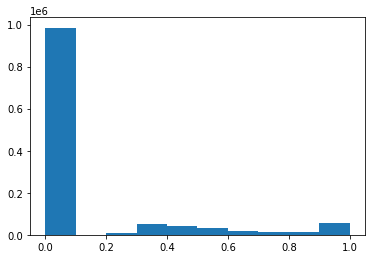

In [6]:
import matplotlib.pyplot as plt
plt.hist(global_error_list[0]) 

Create Train & Test Sets for Input

In [7]:
rating_category = 0 # Choose a category
print(len(global_error_list[rating_category]))
print(len(global_fen_list[rating_category]))

# Shuffle the list so similar positions don't end up near each other
shuffled_list = [i for i in range(len(global_fen_list[rating_category]))]
random.shuffle(shuffled_list)

testing_amount = 10000
training_amount = 1205996

train_fen_list = []
train_error_list = []

test_fen_list = []
test_error_list = []

# Split data to test and train sets
for i in range(len(shuffled_list)):
  if i < training_amount:
    train_fen_list.append(global_fen_list[rating_category][shuffled_list[i]])
    train_error_list.append(global_error_list[rating_category][shuffled_list[i]])
  else:
    test_fen_list.append(global_fen_list[rating_category][shuffled_list[i]])
    test_error_list.append(global_error_list[rating_category][shuffled_list[i]])

1215996
1215996


In [8]:
train_error_indices = [] # Indicies of training examples of error
train_error_amounts = [] # List of errors

train_zero_indices = [] # Indices of 0 error exampes for training

for i in range(len(train_fen_list)):
  processed_error = train_error_list[i] # 0 to 1 scalar
  if processed_error > 0: # If there's an error
    train_error_indices.append(i)
    train_error_amounts.append(processed_error)
  else:
    train_zero_indices.append(i)

print("Length Errors", len(train_error_indices), len(train_error_amounts))
amount_correct = len(train_fen_list) - len(train_error_amounts)
amount_incorrect = len(train_error_amounts)

categorical_train_index = min(amount_correct, amount_incorrect)

# Turn regression lists into numpy arrays
regression_train_x = np.zeros((amount_incorrect, 769))
regression_train_y = np.asarray(train_error_amounts)

categorical_correct_x = np.zeros((amount_correct, 769))
categorical_incorrect_x = np.zeros((amount_incorrect, 769))

for i in tqdm(range(amount_incorrect)):
  regression_train_x[i] = flat_input(train_fen_list[train_error_indices[i]])
  categorical_incorrect_x[i] = flat_input(train_fen_list[train_error_indices[i]])

correct_indices = random.sample(train_zero_indices, categorical_train_index)

for i in tqdm(range(len(correct_indices))):
  categorical_correct_x[i] = flat_input(train_fen_list[correct_indices[i]])

categorical_train_x = np.zeros((2 * categorical_train_index, 769))
categorical_train_y = np.zeros((2 * categorical_train_index,))

for i in tqdm(range(categorical_train_index)):
  categorical_train_x[2 * i] = categorical_correct_x[i]
  categorical_train_y[2 * i] = 0
  categorical_train_x[2 * i + 1] = categorical_incorrect_x[i]
  categorical_train_y[2 * i + 1] = 1

print("CTrainX Shape", categorical_train_x.shape)
print("CTrainY Shape", categorical_train_y.shape)

print("RTrainX Shape", regression_train_x.shape)
print("RTrainY Shape", regression_train_y.shape)

Length Errors 229215 229215


100%|██████████| 229215/229215 [00:01<00:00, 192924.85it/s]

CTrainX Shape (458430, 769)
CTrainY Shape (458430,)
RTrainX Shape (229215, 769)
RTrainY Shape (229215,)


In [9]:
test_error_indices = [] # Indicies of test examples of error
test_error_amounts = [] # List of errors

categorical_test_x = np.zeros((len(test_fen_list), 769))
categorical_test_y = np.zeros((len(test_fen_list),))

for i in tqdm(range(len(test_fen_list))):
  processed_error = test_error_list[i] # 0 to 1 scalar
  
  categorical_test_x[i] = flat_input(test_fen_list[i])
  categorical_test_y[i] = 1 if processed_error > 0 else 0
  
  if processed_error > 0: # If there's an error
    test_error_indices.append(i)
    test_error_amounts.append(processed_error)

# Turn regression lists into numpy arrays
regression_test_x = np.zeros((len(test_error_amounts), 769))
regression_test_y = np.asarray(test_error_amounts)

for i in tqdm(range(len(test_error_amounts))):
  regression_test_x[i] = flat_input(test_fen_list[test_error_indices[i]])

100%|██████████| 1956/1956 [00:00<00:00, 30399.93it/s]


Model

In [0]:
lr = 0.001

class MLP:
  def __init__(self, learning_rate, classification): # Input - learning_rate, boolean classification [T] or regression [F]
      self.learning_rate = learning_rate
      if classification:
        self.model = self.build_classification_model()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                                  loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
      else:
        self.model = self.build_regression_model()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                                 loss='mse',metrics=['mae', 'mse'])

  def build_classification_model(self):
      model = Sequential()

      model.add(Dense(1048, input_dim=769))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))

      model.add(Dense(500))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))

      model.add(Dense(50))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))

      model.add(Dense(2))
      model.add(Activation('softmax'))
      
      model.summary()
      return model

  def build_regression_model(self):
      model = Sequential()

      model.add(Dense(1048, input_dim=769))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))

      model.add(Dense(500))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))

      model.add(Dense(50))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))

      model.add(Dense(1))
      
      model.summary()
      return model

  def train(self, x, y, val_x, val_y):
      history = self.model.fit(x, y, epochs=1, verbose=1, validation_data=(val_x, val_y))
      return history 

In [11]:
import matplotlib.pyplot as plt

print(categorical_train_x.shape)
print(categorical_train_y.shape)
print(regression_train_x.shape)
print(regression_train_y.shape)

print(categorical_test_x.shape)
print(categorical_test_y.shape)
print(regression_test_x.shape)
print(regression_test_y.shape)

(458430, 769)
(458430,)
(229215, 769)
(229215,)
(10000, 769)
(10000,)
(1956, 769)
(1956,)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1048)              806960    
_________________________________________________________________
activation_7 (Activation)    (None, 1048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               524500    
_________________________________________________________________
activation_8 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)               

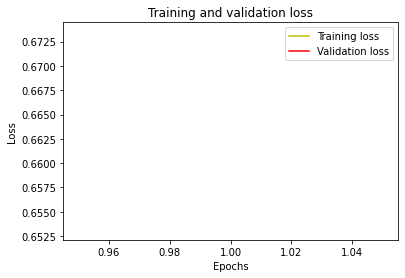

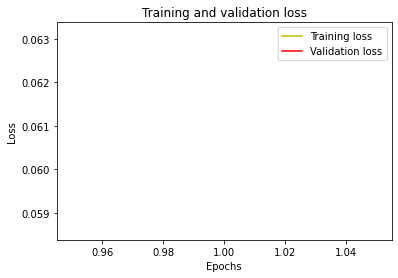

In [13]:
classification_network = MLP(lr, True)
regression_network = MLP(lr, False)

first_train_hist = classification_network.train(categorical_train_x, categorical_train_y, categorical_test_x, categorical_test_y)

plt.figure(1)
loss = first_train_hist.history['loss']
val_loss = first_train_hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

second_train_hist = regression_network.train(regression_train_x, regression_train_y, regression_test_x, regression_test_y)

plt.figure(2)
loss = second_train_hist.history['loss']
val_loss = second_train_hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Save and Upload to Google Drive

In [0]:
classification_network.model.save_weights('cat_model_weights.h5')
regression_network.model.save_weights('reg_model_weights.h5')

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file - REPLACE NEXT TWO LINES 
uploaded = drive.CreateFile({'title': '/content/cat_model_weights.h5'}) # Replace with PATH of bestweights if you have it
uploaded.SetContentFile('/content/cat_model_weights.h5') # Replace with PATH of bestweights if you have it
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 13xqsf1NsKzwSzfs1qJ2ZbikJua6bA5vF
